<a href="https://colab.research.google.com/github/Asoub2001/multi-class-tweet-classifier/blob/main/twitter_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# Data manipulation & utilities
import pandas as pd
import numpy as np
import re
import time
import joblib
import os


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing & vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Dimensionality reduction (optional)
from sklearn.decomposition import PCA

# Train/test split
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC



# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score
)

# Label preprocessing for ROC/PR curves
from sklearn.preprocessing import label_binarize


In [104]:
# Load the Data
# Load the JSON dataset into a pandas DataFrame
data = pd.read_json('/content/CETM47_24_5-AS2-Data.json')

#  Preview the data before cleaning (display the first 5 rows)
print("Data Preview Before Cleaning:")
print(data[['text']].head())  # Show the first 5 tweets


Data Preview Before Cleaning:
                                                text
0  The {@Clinton LumberKings@} beat the {@Cedar R...
1  I would rather hear Eli Gold announce this Aub...
2  Someone take my phone away, I’m trying to not ...
3  A year ago, Louisville struggled to beat an FC...
4  Anyone know why the #Dodgers #Orioles game nex...


In [105]:
# Check for null values in the dataset
print(data.isnull().sum())


text          0
date          0
label         0
id            0
label_name    0
dtype: int64


In [106]:
# Check for duplicate rows
print(f"Number of duplicate rows: {data.duplicated().sum()}")


Number of duplicate rows: 0


In [107]:
# Data Preprocessing
# Function to clean the tweet text by removing URLs, user mentions, and special characters
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", '', text)

    # Keep mentions and hashtags (they carry meaning in tweets)
    text = re.sub(r"[^a-zA-Z0-9\s@#]", '', text)

    # Convert to lowercase
    return text.lower()


    # Return the cleaned text
    return text

# Apply the cleaning function to the 'text' column and store the results in a new column
data['cleaned_text'] = data['text'].apply(clean_text)

# Preview the data after cleaning (display the first 5 rows)
print("\nData Preview After Cleaning:")
print(data[['text', 'cleaned_text']].head())  # Show original and cleaned tweets side by side


Data Preview After Cleaning:
                                                text  \
0  The {@Clinton LumberKings@} beat the {@Cedar R...   
1  I would rather hear Eli Gold announce this Aub...   
2  Someone take my phone away, I’m trying to not ...   
3  A year ago, Louisville struggled to beat an FC...   
4  Anyone know why the #Dodgers #Orioles game nex...   

                                        cleaned_text  
0  the @clinton lumberkings@ beat the @cedar rapi...  
1  i would rather hear eli gold announce this aub...  
2  someone take my phone away im trying to not lo...  
3  a year ago louisville struggled to beat an fcs...  
4  anyone know why the #dodgers #orioles game nex...  


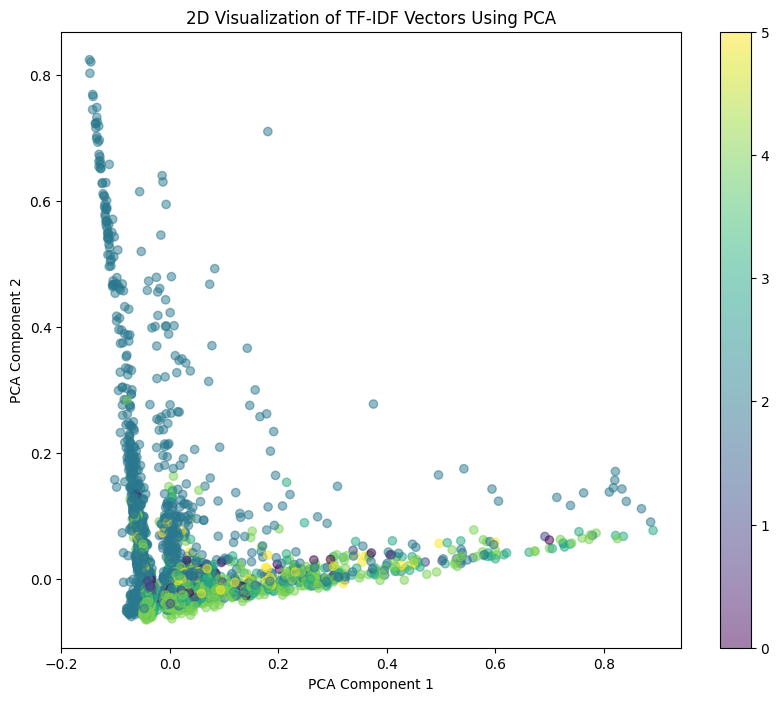

In [108]:

# Text Vectorization
# Convert the cleaned text into numerical representations using TF-IDF (Term Frequency-Inverse Document Frequency)
# TF-IDF helps represent the text as a sparse matrix of numeric features that can be used for machine learning
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_text'])  # Apply the vectorizer to the cleaned text

# Reduce dimensionality using PCA to 2 components
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
X_pca = pca.fit_transform(X.toarray())  # Perform PCA on the dense representation of TF-IDF

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=data['label'], cmap='viridis')  # Scatter plot
plt.colorbar()  # Add a color bar to indicate the labels
plt.title("2D Visualization of TF-IDF Vectors Using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [109]:
# Split the Data
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

In [110]:
# Naive Bayes
nb_model_without_tuning = MultinomialNB()
nb_model_without_tuning.fit(X_train, y_train)
nb_preds_without_tuning = nb_model_without_tuning.predict(X_test)
nb_acc_without_tuning = accuracy_score(y_test, nb_preds_without_tuning) * 100


In [111]:
# Logistic Regression
lr_model_without_tuning = LogisticRegression(max_iter=200, class_weight='balanced')
lr_model_without_tuning.fit(X_train, y_train)
lr_preds_without_tuning = lr_model_without_tuning.predict(X_test)
lr_acc_without_tuning = accuracy_score(y_test, lr_preds_without_tuning) * 100


In [112]:
# SVM
svm_model_without_tuning = LinearSVC(class_weight='balanced')
svm_model_without_tuning.fit(X_train, y_train)
svm_preds_without_tuning = svm_model_without_tuning.predict(X_test)
svm_acc_without_tuning = accuracy_score(y_test, svm_preds_without_tuning) * 100


In [113]:
print("=== Naive Bayes (Without Tuning) ===")
print(f"Accuracy: {nb_acc_without_tuning:.2f}%")
print(classification_report(y_test, nb_preds_without_tuning))
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_preds_without_tuning))

print("\n=== Logistic Regression (Without Tuning) ===")
print(f"Accuracy: {lr_acc_without_tuning:.2f}%")
print(classification_report(y_test, lr_preds_without_tuning))
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_preds_without_tuning))

print("\n=== SVM (Without Tuning) ===")
print(f"Accuracy: {svm_acc_without_tuning:.2f}%")
print(classification_report(y_test, svm_preds_without_tuning))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_preds_without_tuning))


=== Naive Bayes (Without Tuning) ===
Accuracy: 74.79%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       1.00      0.08      0.15        60
           2       0.70      0.92      0.80       497
           3       0.77      0.30      0.43       179
           4       0.79      0.95      0.86       468
           5       0.71      0.08      0.15        60

    accuracy                           0.75      1289
   macro avg       0.66      0.39      0.40      1289
weighted avg       0.75      0.75      0.70      1289

Confusion Matrix:
[[  0   0  19   2   4   0]
 [  0   5  25   9  20   1]
 [  0   0 455   2  39   1]
 [  0   0  89  54  36   0]
 [  0   0  23   0 445   0]
 [  0   0  35   3  17   5]]

=== Logistic Regression (Without Tuning) ===
Accuracy: 79.44%
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        25
           1       0.58      0.53      0.56       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [114]:
# Naive Bayes (Tuned)
nb_params = {'alpha': [0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}
nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=3, scoring='accuracy', n_jobs=-1)
nb_grid.fit(X_train, y_train)
nb_model_with_tuning = nb_grid.best_estimator_
nb_preds_with_tuning = nb_model_with_tuning.predict(X_test)
nb_acc_with_tuning = accuracy_score(y_test, nb_preds_with_tuning) * 100

In [115]:
# Logistic Regression (Tuned)
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=200), lr_params, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)
lr_model_with_tuning = lr_grid.best_estimator_
lr_preds_with_tuning = lr_model_with_tuning.predict(X_test)
lr_acc_with_tuning = accuracy_score(y_test, lr_preds_with_tuning) * 100


In [116]:
# SVM (Tuned)
svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': ['balanced']
}
svm_grid = GridSearchCV(LinearSVC(), svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_model_with_tuning = svm_grid.best_estimator_
svm_preds_with_tuning = svm_model_with_tuning.predict(X_test)
svm_acc_with_tuning = accuracy_score(y_test, svm_preds_with_tuning) * 100


In [117]:
print("\n=== Naive Bayes (With Tuning) ===")
print(f"Accuracy: {nb_acc_with_tuning:.2f}%")
print(classification_report(y_test, nb_preds_with_tuning))
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_preds_with_tuning))

print("\n=== Logistic Regression (With Tuning) ===")
print(f"Accuracy: {lr_acc_with_tuning:.2f}%")
print(classification_report(y_test, lr_preds_with_tuning))
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_preds_with_tuning))

print("\n=== SVM (With Tuning) ===")
print(f"Accuracy: {svm_acc_with_tuning:.2f}%")
print(classification_report(y_test, svm_preds_with_tuning))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_preds_with_tuning))



=== Naive Bayes (With Tuning) ===
Accuracy: 80.29%
              precision    recall  f1-score   support

           0       0.71      0.20      0.31        25
           1       0.75      0.45      0.56        60
           2       0.86      0.80      0.83       497
           3       0.60      0.71      0.65       179
           4       0.86      0.94      0.90       468
           5       0.62      0.63      0.63        60

    accuracy                           0.80      1289
   macro avg       0.73      0.62      0.65      1289
weighted avg       0.81      0.80      0.80      1289

Confusion Matrix:
[[  5   0   8   7   3   2]
 [  0  27   6  15   9   3]
 [  1   3 400  42  38  13]
 [  0   4  29 127  16   3]
 [  1   2  15  10 438   2]
 [  0   0   7  11   4  38]]

=== Logistic Regression (With Tuning) ===
Accuracy: 82.54%
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        25
           1       0.77      0.50      0.61        60
 

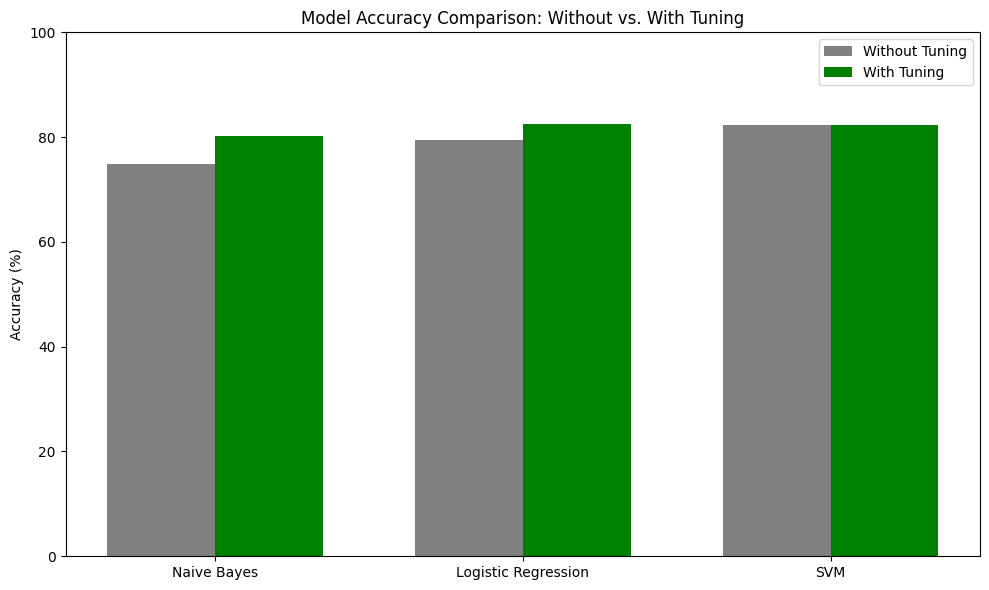

In [118]:
# ============================
# ACCURACY COMPARISON PLOT
# ============================

models = ['Naive Bayes', 'Logistic Regression', 'SVM']
without_tuning = [nb_acc_without_tuning, lr_acc_without_tuning, svm_acc_without_tuning]
with_tuning = [nb_acc_with_tuning, lr_acc_with_tuning, svm_acc_with_tuning]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, without_tuning, width, label='Without Tuning', color='gray')
plt.bar(x + width/2, with_tuning, width, label='With Tuning', color='green')

plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison: Without vs. With Tuning')
plt.xticks(x, models)
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

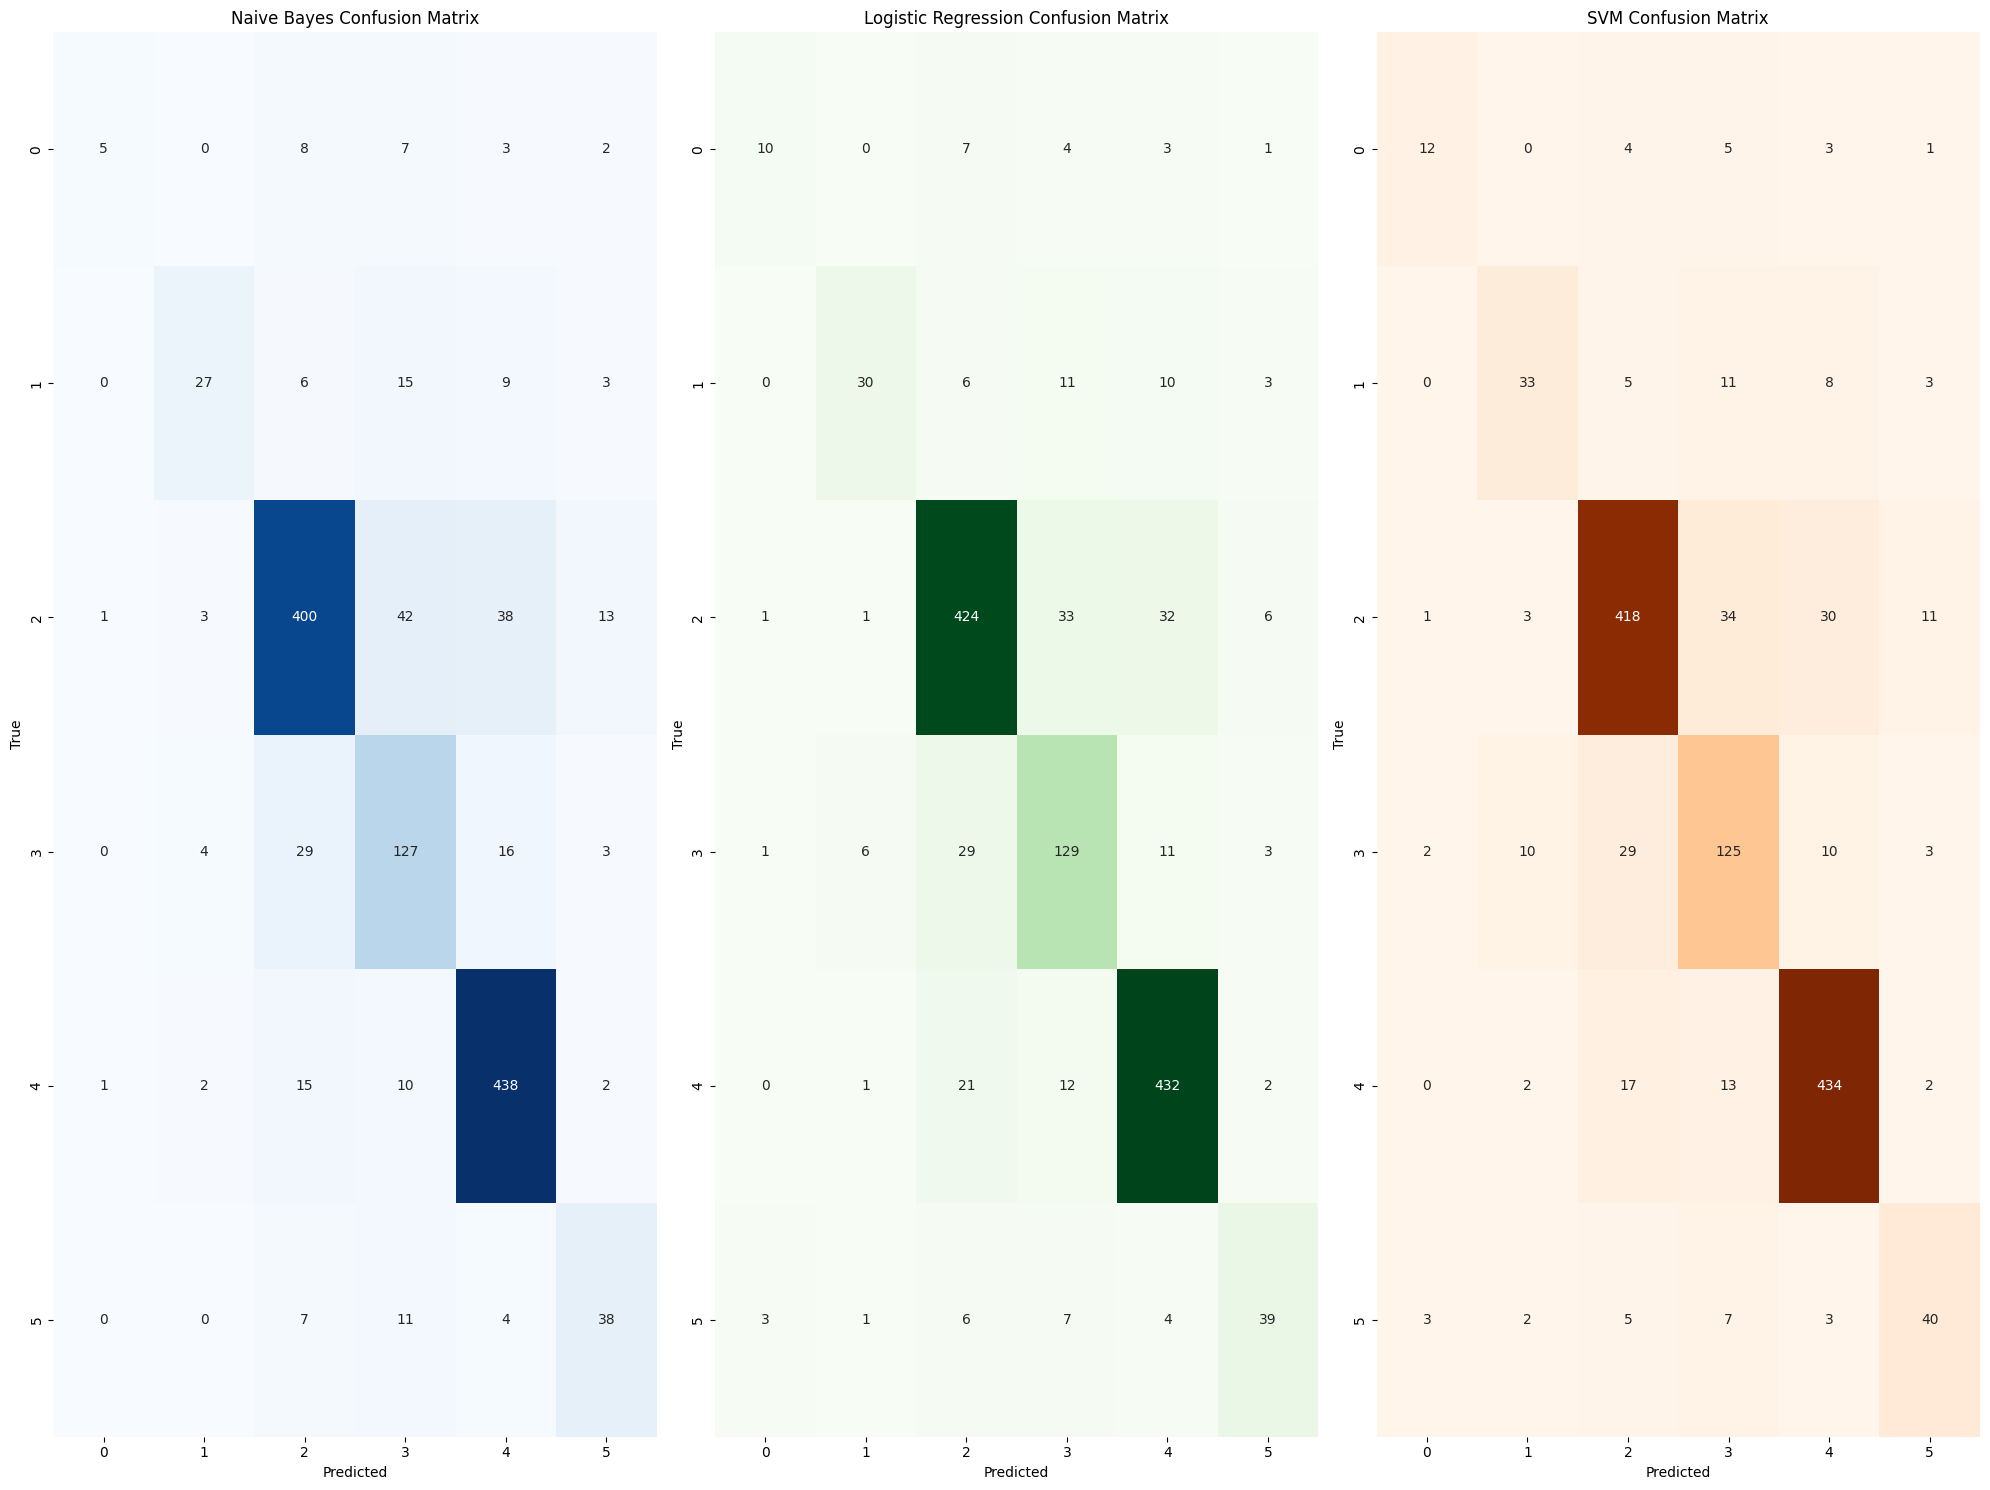

In [119]:


# Generate confusion matrices for the tuned models
nb_cm = confusion_matrix(y_test, nb_predictions)
lr_cm = confusion_matrix(y_test, lr_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)



# Plotting the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 15))

# Naive Bayes Confusion Matrix
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Naive Bayes Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Logistic Regression Confusion Matrix
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# SVM Confusion Matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title('SVM Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')


plt.tight_layout()
plt.show()

In [120]:

# Prepare metrics for each model
models_summary = {
    'Naive Bayes': nb_predictions,
    'Logistic Regression': lr_predictions,
    'SVM': svm_predictions
}

print("\nModel Performance Summary:\n")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1"))
for name, preds in models_summary.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='macro')
    rec = recall_score(y_test, preds, average='macro')
    f1 = f1_score(y_test, preds, average='macro')
    print("{:<20} {:.4f}    {:.4f}    {:.4f}    {:.4f}".format(name, acc, prec, rec, f1))



Model Performance Summary:

Model                Accuracy   Precision  Recall     F1        
Naive Bayes          0.8029    0.7348    0.6223    0.6470
Logistic Regression  0.8254    0.7591    0.6745    0.7058
SVM                  0.8239    0.7330    0.6939    0.7098


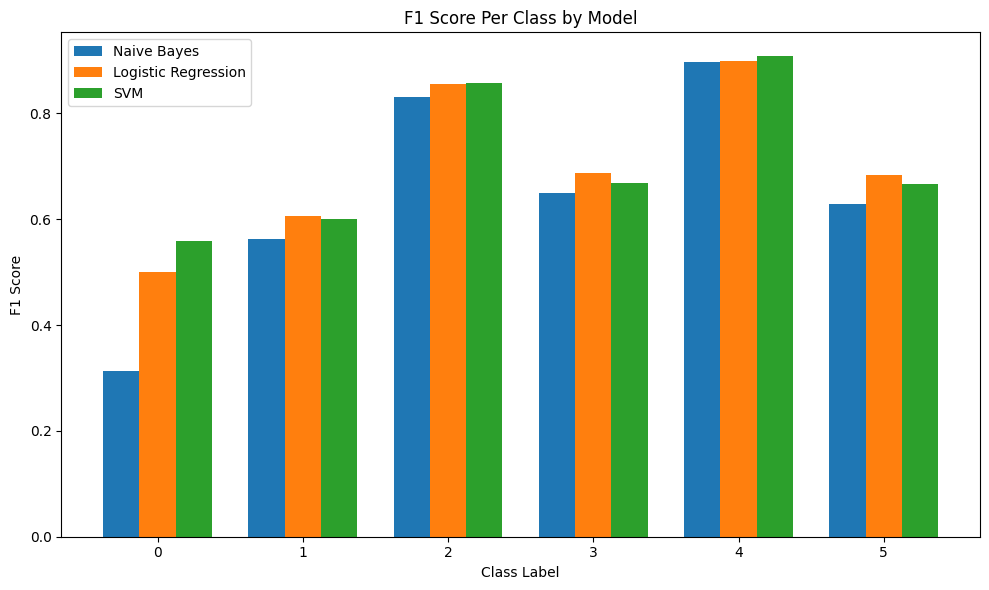

In [121]:

labels = [0, 1, 2, 3, 4, 5]
nb_f1 = f1_score(y_test, nb_predictions, average=None, labels=labels)
lr_f1 = f1_score(y_test, lr_predictions, average=None, labels=labels)
svm_f1 = f1_score(y_test, svm_predictions, average=None, labels=labels)


x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, nb_f1, width, label='Naive Bayes')
plt.bar(x, lr_f1, width, label='Logistic Regression')
plt.bar(x + width, svm_f1, width, label='SVM')
plt.xlabel('Class Label')
plt.ylabel('F1 Score')
plt.title('F1 Score Per Class by Model')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


In [122]:
# === Execution Time for Non-Tuned Models ===

# Naive Bayes (Non-Tuned)
start_time = time.time()
nb_model_non_tuned = MultinomialNB()
nb_model_non_tuned.fit(X_train, y_train)
nb_train_time_non_tuned = time.time() - start_time

# Logistic Regression (Non-Tuned)
start_time = time.time()
lr_model_non_tuned = LogisticRegression(max_iter=200, class_weight='balanced')
lr_model_non_tuned.fit(X_train, y_train)
lr_train_time_non_tuned = time.time() - start_time

# SVM (Non-Tuned)
start_time = time.time()
svm_model_non_tuned = LinearSVC(class_weight='balanced')
svm_model_non_tuned.fit(X_train, y_train)
svm_train_time_non_tuned = time.time() - start_time



# === Execution Time for Tuned Models ===

# Naive Bayes (Tuned)
start_time = time.time()
nb_model_tuned = MultinomialNB(**nb_grid.best_params_)
nb_model_tuned.fit(X_train, y_train)
nb_train_time_tuned = time.time() - start_time

# Logistic Regression (Tuned)
start_time = time.time()
lr_model_tuned = LogisticRegression(**lr_grid.best_params_, max_iter=200)
lr_model_tuned.fit(X_train, y_train)
lr_train_time_tuned = time.time() - start_time

# SVM (Tuned)
start_time = time.time()
svm_model_tuned = LinearSVC(**svm_grid.best_params_)
svm_model_tuned.fit(X_train, y_train)
svm_train_time_tuned = time.time() - start_time

print("\n=== Training Time Comparison (Seconds) ===")
print("{:<25} {:<15} {:<15}".format("Model", "Non-Tuned", "Tuned"))
print("{:<25} {:.4f}        {:.4f}".format("Naive Bayes", nb_train_time_non_tuned, nb_train_time_tuned))
print("{:<25} {:.4f}        {:.4f}".format("Logistic Regression", lr_train_time_non_tuned, lr_train_time_tuned))
print("{:<25} {:.4f}        {:.4f}".format("SVM", svm_train_time_non_tuned, svm_train_time_tuned))



=== Training Time Comparison (Seconds) ===
Model                     Non-Tuned       Tuned          
Naive Bayes               0.0043        0.0036
Logistic Regression       1.8176        0.1347
SVM                       0.1577        0.0858


In [123]:
trained_models = {
    'NaiveBayes': nb_model_with_tuning,
    'LogisticRegression': lr_model_with_tuning,
    'SVM': svm_model_with_tuning
}

joblib.dump(trained_models, 'models/trained_models.pkl')
print("Models saved to 'models/trained_models.pkl'")


Models saved to 'models/trained_models.pkl'
